In [1]:
from math import ceil, log, floor
from pathlib import Path
import pandas as pd
import numpy as np
from random import randint
from sys import getsizeof
from collections.abc import Generator, Callable
from collections import defaultdict

What data do I want to retrieve from all the files?

Looping through all the files, I can aggregate data from each file.
Each row has a bike ID which gives it a distinctive quality.
Values are:
   - Lat, Lng pairs for start and end
   - Starting and ending datetime
Categories are:
   - Bike type (Electric: True, Classic: False)
   - Member type (Member: True, Casual: False)
   - Stating and ending station name or float ID

Potential routes are:
   - Create storage 

In [2]:
dir_main = Path('/Users/neelagarwal/Desktop/CITIBike Data/')
dir_nyc = dir_main / 'NYC'
dir_jersey = dir_main / 'Jersey'

def iter_subfiles(parent: Path, year: int):
    dir_year = parent / f'{year}'

    if parent.stem == 'NYC':
        for dir_month in sorted(dir_year.iterdir()):
            dir_month: Path
            if dir_month.is_dir():
                for csv in sorted(dir_month.iterdir()):
                    csv: Path
                    if csv.is_file() and csv.suffix == '.csv':
                        yield csv.resolve()
                        
    elif parent.stem == 'Jersey':
        for csv in sorted(dir_year.iterdir()):
            csv: Path
            if csv.is_file() and csv.suffix == '.csv':
                yield csv.resolve()

def csv_generator(parent, year):
    for file in iter_subfiles(parent, year):
        yield pd.read_csv(file, low_memory = False), file

def csv_to_df(parent: Path, year: int, selected_file_num: int | None = None) -> Generator[pd.DataFrame] | pd.DataFrame | str:
    if selected_file_num is None:
        return csv_generator(parent, year)
    elif selected_file_num is not None:
        for num, file in enumerate(iter_subfiles(parent, year)):
            if num == selected_file_num:
                return pd.read_csv(file, low_memory = False), file


def generate_randint(start: int, stop: int):
    while True:
        yield randint(start, stop)

random_int = generate_randint(0, 2)

def get_all_columns(parent: Path, years: list[int]):
    all_cols = [csv_to_df(parent, year, next(random_int), just_headers = True) for year in years]
    return [(list(cols) if cols else None) for cols in all_cols]

def digits_in_words(digits: int):
    term = str(len(str(digits)))
    stmt_map = {
        '0': 'None'
        ,'1': 'Ones'
        ,'2': 'Tens'
        ,'3': 'Hundreds'
        ,'4': 'Thousands'
        ,'5': 'Tens of thousands'
        ,'6': 'Hundreds of thousands'
        ,'7': 'Millions'
        ,'8': 'Tens of millions'
        ,'9': 'Hundreds of millions'
        ,'10': 'Billions'
        ,'11': 'Tens of billions'
        ,'12': 'Hundreds of billions'
        ,'13': 'Trillions'
        ,'14': 'Tens of trillions'
        ,'15': 'Hundreds of trillions'
    }
    return stmt_map.get(term, 'None')

def convert_size(size_bytes):
    if size_bytes == 0:
        return '0B'
    size_name = ('B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB')
    i = int(floor(log(size_bytes, 1024)))
    p = 1024**i
    s = round(size_bytes / p, 2)
    return '%s %s' % (s, size_name[i])

def size_stmt_from_size(size: int):
    print(
        f'Bytes: {size}\n'
        f'Digits: {digits_in_words(size)}\n'
        f'Simplified: {convert_size(size)}'
    )
    return size

def size_stmt_delta(size: int):
    print('*DELTA SIZE*')
    size_stmt_from_size(size)
    return None

def size_stmt_from_df(df: pd.DataFrame):
    size = getsizeof(df)
    size_stmt_from_size(size)
    return size

def add_to_csv(path: Path, data: list | tuple, time_period: str | int) -> None:
    time_period = str(time_period)
    if path.exists():
        df = pd.read_csv(path, low_memory = False)
        if time_period not in df.columns:
            df[time_period] = data
        else:
            raise RuntimeError('Time period already exists in this dataframe.')
    else:
        df = pd.DataFrame({time_period: data})
    df.to_csv(path, header = True, index = False)
    return None

In [3]:
def haversine_vectorized(lat1: pd.Series, lng1: pd.Series, lat2: pd.Series, lng2: pd.Series, unit = 'km' or 'mi') -> pd.Series:
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    delta_lat = lat2 - lat1
    delta_lng = lng2 - lng1
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lng / 2.0)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    if unit == 'km':
        R = 6371
    elif unit == 'mi':
        R = 3959
    result: pd.Series
    result = R * c
    return result

In [ ]:
class Features:
    def __init__(self, df: pd.DataFrame, file: Path):
        self.file = file
        self.dt_from_dir()
        self.main_df = df.copy()
        self.station_csv = Path('station_data.csv')
        self.field_variations().value_mapping()
        self.clean_df().add_calculations()
        # self.extract_and_normalize_stations()
    
    def dt_from_dir(self):
        path_components = self.file.parent.parts
        _month = path_components[-1]
        month = str().join(filter(str.isalpha, _month))
        year = path_components[-2]
        self.month_year = f'{year}_{month}'
        return self

    def field_variations(self):
        self.fields = ['ride_id', 'if_electric_bike'
            ,'start_dt', 'end_dt'
            ,'start_station', 'end_station'
            ,'start_id', 'end_id'
            ,'start_lat', 'start_lng'
            ,'end_lat', 'end_lng'
            ,'if_member'
        ]
        self.col_name_map = {
            'bikeid':  'ride_id'
            ,'bike id': 'ride_id'

            ,'rideable_type': 'if_electric_bike'

            ,'started_at': 'start_dt'
            ,'starttime': 'start_dt'
            ,'start time': 'start_dt'

            ,'ended_at': 'end_dt'
            ,'stoptime': 'end_dt'
            ,'stop time': 'end_dt'

            ,'start_station_name': 'start_station'
            ,'start station name': 'start_station'

            ,'end_station_name': 'end_station'
            ,'end station name': 'end_station'

            ,'start_station_id': 'start_id'
            ,'start station id': 'start_id'

            ,'end_station_id': 'end_id'
            ,'end station id': 'end_id'

            ,'start station latitude': 'start_lat'
            ,'start station longitude': 'start_lng'

            ,'end station latitude': 'end_lat'
            ,'end station longitude': 'end_lng'

            ,'member_casual': 'if_member'
            ,'usertype': 'if_member'
            ,'user type': 'if_member'
        }
        return self
    
    def value_mapping(self):
        self.bike_type_map = {'classic_bike': False, 'electric_bike': True}
        self.membership_map = {
            'casual': False, 'member': True,
            'Customer': False, 'Subscriber': True
        }
        return self
    
    def clean_df(self):
        self.main_df.dropna(how = 'any', inplace = True)
        self.main_df.columns = [col.lower() for col in self.main_df.columns]
        self.main_df.rename(columns = self.col_name_map, inplace = True)
        if 'if_electric_bike' in list(self.main_df.columns):
            self.main_df['if_electric_bike'] = self.main_df['if_electric_bike'].map(self.bike_type_map).astype(bool)
        else:
            self.main_df['if_electric_bike'] = False
        self.main_df['if_member'] = self.main_df['if_member'].map(self.membership_map).astype(bool)

        self.main_df['start_dt'] = pd.to_datetime(self.main_df['start_dt'])
        self.main_df['end_dt'] = pd.to_datetime(self.main_df['end_dt'])

        self.main_df = self.main_df[self.fields].copy()
        return self

    def add_calculations(self):
        self.main_df['duration_sec'] = pd.to_timedelta(self.main_df['end_dt'] - self.main_df['start_dt']).dt.total_seconds()
        unit = 'mi'
        self.main_df[f'distance_{unit}'] = haversine_vectorized(
            self.main_df['start_lat']
            ,self.main_df['start_lng']
            ,self.main_df['end_lat']
            ,self.main_df['end_lng']
            ,unit
        ).round(4)
        return self
    
    def extract_and_normalize_stations(self):
        new_stations = pd.concat([self.main_df['start_station'], self.main_df['end_station']], axis = 0).drop_duplicates(keep = 'first')

        if self.station_csv.exists():
            station_data = pd.read_csv(self.station_csv)
            stations = pd.concat([station_data['name'], new_stations], axis = 0).drop_duplicates(keep = 'first')
        else:
            stations = new_stations
        stations = stations.to_list()

        station_ids = list(range(1, len(stations) + 1))
        id_mapping = {str(station): id for id, station in zip(station_ids, stations)}

        self.main_df['start_station'] = self.main_df['start_station'].map(id_mapping)
        self.main_df['end_station'] = self.main_df['end_station'].map(id_mapping)
        self.main_df.drop(columns = ['start_id', 'end_id'], inplace = True)
        self.station_table = pd.DataFrame({'id': station_ids, 'name': stations})
        self.station_table.to_csv(self.station_csv, header = True, index = False)
        return self
    
    def merged_stations_table(self, df: pd.DataFrame | pd.Series | None = None) -> pd.DataFrame:
        if df is not None:
            if isinstance(df, pd.DataFrame):
                pass
            elif isinstance(df, pd.Series):
                df = pd.DataFrame(df)
        elif df is None:
            df = self.main_df

        if 'start_station' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_on = 'start_station', right_on = 'id'
            ).drop(columns = ['start_station', 'id']
            ).rename(columns = {'name': 'start_station'}
            ).copy()
        if 'end_station' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_on = 'end_station', right_on = 'id'
            ).drop(columns = ['end_station', 'id']
            ).rename(columns = {'name': 'end_station'}
            ).copy()
        if 'total_distances' in df.columns or 'station_freq' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_index = True, right_on = 'id'
            ).drop(columns = ['id']
            ).rename(columns = {'name': 'station'}
            ).set_index('station', drop = True
            ).copy()
        return df

    def get_by_attr(self, df: str):
        return self.__getattribute__(df)
    
    def get_by_method(self, method: str):
        return getattr(self, method)

    def get_distance_per_station(self, aggr_func: Callable[[], pd.DataFrame] = pd.Series.sum):
        df = self.main_df
        distance_per_startStation = pd.DataFrame(df.groupby('start_station')['distance_mi'].agg(aggr_func))
        distance_per_endStation = pd.DataFrame(df.groupby('end_station')['distance_mi'].agg(aggr_func))
        distance_per_station = distance_per_startStation.merge(distance_per_endStation, how = 'inner', left_index = True, right_index = True)
        distance_per_station['distance_aggr'] = distance_per_station['distance_mi_x'] + distance_per_station['distance_mi_y']
        distance_per_station = distance_per_station['distance_aggr']
        return distance_per_station
    
    def get_duration_per_station(self, aggr_func: Callable[[], pd.DataFrame] = pd.Series.sum):
        df = self.main_df
        duration_per_startStation = pd.DataFrame(df.groupby('start_station')['duration_sec'].agg(aggr_func))
        duration_per_endStation = pd.DataFrame(df.groupby('end_station')['duration_sec'].agg(aggr_func))
        duration_per_station = duration_per_startStation.merge(duration_per_endStation, how = 'inner', left_index = True, right_index = True)
        duration_per_station['duration_aggr'] = duration_per_station['duration_sec_x'] + duration_per_station['duration_sec_y']
        duration_per_station = duration_per_station['duration_aggr']
        return duration_per_station
    
    def get_station_freq(self):
        df = self.main_df
        start_station_view = df.groupby('start_station')['ride_id'].count()
        end_station_view = df.groupby('end_station')['ride_id'].count()
        view = pd.concat([start_station_view, end_station_view], axis = 1)
        view.fillna(0, inplace = True)
        view['station_freq'] = view.iloc[:, 0] + view.iloc[:, 1]
        station_freq = view['station_freq'].astype(int).copy()
        return station_freq
    
    def get_counts_per_hour(self):
        df = self.main_df
        counts_per_hour = df.groupby(df['start_dt'].dt.hour)['ride_id'].count()
        counts_per_hour.name = 'Counts'
        counts_per_hour.index.name = 'Hour'
        return counts_per_hour
    
    def get_counts_per_day(self):
        df = self.main_df
        # counts_per_day = df.groupby(df['start_dt'].dt.day)['ride_id'].count()
        # counts_per_day.name = 'Counts'
        # counts_per_day.index.name = 'Day'
        daily_counts = df.groupby(df['start_dt'].dt.date)['ride_id'].count()
        daily_counts.name = 'Daily Ride Counts'
        daily_counts.reset_index().to_csv('daily_ride_counts.csv', index=False)
        return daily_counts
    
    def get_membership_per_day(self):
        df = self.main_df
        # members_per_day = df.groupby([df['start_dt'].dt.day, 'if_member'])[df.columns[0]].count()
        # members_per_day.name = 'if_member'
        # members_per_day.index.name = 'Day'
        membership_breakdown = df.groupby(['start_dt', 'if_member'])['ride_id'].count().unstack(fill_value=0)
        membership_breakdown.columns = ['Casual', 'Member']
        membership_breakdown.reset_index().to_csv('membership_breakdown.csv', index=False)
        return membership_breakdown

    def get_electric_bike_counts(self):
        df = self.main_df
        electric_bike_counts = df.groupby([df['start_dt'].dt.day, 'if_electric_bike'])[df.columns[0]].count()
        electric_bike_counts.name = 'if_electric_bike'
        electric_bike_counts.index.name = 'Day'
        return electric_bike_counts

# 
#
#

def convert_nans(df: pd.DataFrame, cols: pd.DatetimeIndex): 
    for ts in cols:
        df.loc[ts.days_in_month + 1 :, ts.strftime('%Y_%b')] = pd.NA
    return df

def build_counts_per_dt(parent_dir: Path):
    hour_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    day_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    member_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    years = list(range(2013, 2026))
    for year in years:
        for obj_iter in csv_to_df(parent_dir, year):
            feats = Features(*obj_iter)
            hour_counts = feats.get_counts_per_hour()
            day_counts = feats.get_counts_per_day()
            members_bool = feats.get_membership_per_day()
            month_key = feats.month_year
            print(f'Looping for: {month_key}')
            hour_bins[month_key] = hour_bins[month_key].add(hour_counts, fill_value = 0).astype('int64')
            day_bins[month_key] = day_bins[month_key].add(day_counts, fill_value = 0).astype('int64')
            if member_bins[month_key].empty:
                member_bins[month_key] = members_bool.copy()
            else:
                member_bins[month_key] = member_bins[month_key].add(members_bool, fill_value = 0).astype('int64')
    hour_df = pd.DataFrame(hour_bins).reindex(range(0, 24))
    day_df = pd.DataFrame(day_bins).reindex(range(1, 32))
    member_df = pd.DataFrame(member_bins).reindex(range(1, 32), level = 0)
    day_cols = pd.to_datetime(day_df.columns, format="%Y_%b")
    member_cols = pd.to_datetime(member_df.columns, format = '%Y_%b')
    day_df = convert_nans(day_df, day_cols)
    member_df = convert_nans(member_df, member_cols)
    return hour_df, day_df, member_df


def build_electric_bike_counts(parent_dir: Path):
    bike_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    years = list(range(2020, 2026))
    for year in years:
        for obj_iter in csv_to_df(parent_dir, year):
            feats = Features(*obj_iter)
            electric_bikes = feats.get_electric_bike_counts()
            month_key = feats.month_year
            print(f'Looping for: {month_key}')
            bike_bins[month_key] = bike_bins[month_key].add(electric_bikes, fill_values = 0).astype('int64')
    electric_bikes_df = pd.DataFrame(bike_bins).reindex(range(1, 32))
    electric_bikes_cols = pd.to_datetime(electric_bikes_df.columns, format = '%Y_%b')
    return convert_nans(electric_bikes_df, electric_bikes_cols)

In [ ]:
electric_bike_path = Path('NYC/daily_electric_bikes.csv')
if not electric_bike_path.exists():
    electric_bike_df = build_electric_bike_counts(dir_nyc, header = True, index = True)
else:
    electric_bike_df = pd.read_csv(electric_bike_path, index = 0)

In [10]:
for count, obj_iter in enumerate(csv_to_df(dir_nyc, 2025)):
    feat = Features(*obj_iter)
    feat.main_df.to_csv(Path(f'cleaned_file_{count}.csv'), header = True, index = False)

2014 Sept - 2016 Oct

## 1st Major Aggregations
Safeguarded via an if...else check

In [6]:
hourly_counts_path = Path('NYC/hourly_ride_counts.csv')
daily_counts_path = Path('NYC/daily_ride_counts.csv')
daily_membership_path = Path('NYC/daily_membership.csv')
if not hourly_counts_path.exists() or not daily_counts_path.exists() or not daily_membership_path.exists():
    hourly_counts_df, daily_counts_df, daily_members_df = build_counts_per_dt(dir_nyc)
    hourly_counts_df.to_csv(hourly_counts_path, header = True, index = True)
    daily_counts_df.to_csv(daily_counts_path, header = True, index = True)
    daily_members_df.to_csv(daily_membership_path, header = True, index = True)
else:
    hourly_counts_df = pd.read_csv(hourly_counts_path, index_col = 0)
    daily_counts_df = pd.read_csv(daily_counts_path, index_col = 0)
    daily_members_df = pd.read_csv(daily_membership_path, index_col = [0, 1])

In [7]:
years = [str(year) for year in list(range(2013, 2026))]
counts_by_year = {}
counts_by_year[years[0]] = int(daily_counts_df.iloc[:, 0:7].sum().sum())
end_pos = 7
for i in range(1, len(years)):
    start_pos = 0
    counts_by_year[years[i]] = int(daily_counts_df.iloc[:, start_pos : end_pos].sum().sum())
    start_pos = end_pos
    end_pos += 12

In [8]:
counts_by_year

{'2013': 5364026,
 '2014': 5364026,
 '2015': 13232308,
 '2016': 21858899,
 '2017': 34081875,
 '2018': 48800313,
 '2019': 66346155,
 '2020': 86897672,
 '2021': 106411152,
 '2022': 133444509,
 '2023': 163211715,
 '2024': 198211285,
 '2025': 242469415}

In [302]:
yearly_counts_path = Path('NYC/Deeper/yearly_membership.csv')
pd.DataFrame(counts_by_year, index = [0]).to_csv(yearly_counts_path, header = True)

In [245]:
daily_counts_df.iloc[:, 7:20].sum(axis = 1)

Day
1     250268.0
2     272773.0
3     253060.0
4     242115.0
5     260138.0
6     255788.0
7     273731.0
8     270832.0
9     257697.0
10    285324.0
11    293521.0
12    284302.0
13    243541.0
14    276223.0
15    267538.0
16    265096.0
17    291574.0
18    277452.0
19    275284.0
20    294508.0
21    286480.0
22    264229.0
23    260568.0
24    269817.0
25    263728.0
26    239482.0
27    257520.0
28    266103.0
29    251105.0
30    245290.0
31    153119.0
dtype: float64

In [226]:
daily_members_df = pd.read_csv(daily_membership_path, index_col = [0, 1])
subsect = daily_members_df.iloc[:, 15:41]
subsect.head()

2014_Sep  2014_Oct  2014_Nov  2014_Dec  2015_Jan  \
start_dt if_member                                                     
1        False           NaN       NaN       NaN       NaN       NaN   
         True        17828.0   26765.0    5689.0   17792.0    4651.0   
2        False           NaN       NaN       NaN       NaN       NaN   
         True        28105.0   32497.0   12947.0   15173.0   10663.0   
3        False           NaN       NaN       NaN       NaN       NaN   

                    2015_Feb  2015_Mar  2015_Apr  2015_May  2015_Jun  ...  \
start_dt if_member                                                    ...   
1        False           NaN       NaN       NaN       NaN       NaN  ...   
         True         6256.0    2761.0   19248.0   25188.0   14458.0  ...   
2        False           NaN       NaN       NaN       NaN       NaN  ...   
         True         1449.0    7194.0   22228.0   18905.0   11512.0  ...   
3        False           NaN       NaN       NaN       NaN       NaN  ...   

                    2016_Jan  2016_Feb  2016_Mar  2016_Apr  2016_May  \
start_dt if_member                                                     
1        False           NaN       NaN       NaN       NaN       NaN   
         True         8508.0   23617.0   28940.0   31319.0    9518.0   
2        False           NaN       NaN       NaN       NaN       NaN   
         True        12134.0   27643.0   25414.0   18707.0   34791.0   
3        False           NaN       NaN       NaN       NaN       NaN   

                    2016_Jun  2016_Jul  2016_Aug  2016_Sep  2016_Oct  
start_dt if_member                                                    
1        False           NaN       1.0       164     206.0       NaN  
         True        49354.0   35319.0     44516   35276.0   33498.0  
2        False           NaN       NaN       229     635.0       NaN  
         True        49017.0   24317.0     50759   44920.0   33176.0  
3        False           NaN       NaN       150    1282.0       NaN  

[5 rows x 26 columns]

In [232]:
member_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
years = list(range(2014, 2016))
for year in years:
    for obj_iter in csv_to_df(dir_nyc, year):
        feats = Features(*obj_iter)
        members_bool = feats.get_membership_per_day()
        month_key = feats.month_year
        print(f'Looping for: {month_key}')
        if member_bins[month_key].empty:
            member_bins[month_key] = members_bool.copy()
        else:
            member_bins[month_key] = member_bins[month_key].add(members_bool, fill_value = 0).astype('int64')
old_member_df = pd.DataFrame(member_bins).reindex(range(1, 32), level = 0)
member_cols = pd.to_datetime(old_member_df.columns, format = '%Y_%b')
new_member_df = convert_nans(old_member_df, member_cols)

Looping for: 2014_Jan
Looping for: 2014_Feb
Looping for: 2014_Mar
Looping for: 2014_Apr
Looping for: 2014_May
Looping for: 2014_Jun
Looping for: 2014_Jul
Looping for: 2014_Aug
Looping for: 2014_Sep
Looping for: 2014_Oct
Looping for: 2014_Nov
Looping for: 2014_Dec
Looping for: 2015_Jan
Looping for: 2015_Feb
Looping for: 2015_Mar
Looping for: 2015_Apr
Looping for: 2015_May
Looping for: 2015_Jun
Looping for: 2015_Jul
Looping for: 2015_Jul
Looping for: 2015_Aug
Looping for: 2015_Aug
Looping for: 2015_Sep
Looping for: 2015_Sep
Looping for: 2015_Oct
Looping for: 2015_Oct
Looping for: 2015_Nov
Looping for: 2015_Dec


In [234]:
old_member_df

2014_Jan  2014_Feb  2014_Mar  2014_Apr  2014_May  \
start_dt if_member                                                     
1        False           652     744.0       588    1136.0      1692   
         True           5407   12027.0      8614   22772.0     25070   
2        False           181     979.0       437     643.0      3050   
         True           8419   12837.0      7758   21872.0     29327   
3        False            21      22.0       125    1359.0      5354   
...                      ...       ...       ...       ...       ...   
29       True           9966       NaN      4233   17778.0     30989   
30       False           113       NaN       464      49.0      3377   
         True          12045       NaN      7443    2818.0     30966   
31       False           237       NaN       598       NaN      6068   
         True          14416       NaN     16487       NaN     21666   

                    2014_Jun  2014_Jul  2014_Aug  2014_Sep  2014_Oct  ...  \
start_dt if_member                                                    ...   
1        False        7291.0      2682      3323       NaN       NaN  ...   
         True        24042.0     32172     29331   17828.0   26765.0  ...   
2        False        3395.0      2093      6285       NaN       NaN  ...   
         True        31124.0     24489     20499   28105.0   32497.0  ...   
3        False        2253.0      2439      5769       NaN       NaN  ...   
...                      ...       ...       ...       ...       ...  ...   
29       True        21632.0     34000     27506   30669.0   28491.0  ...   
30       False        3162.0      3289      6372       NaN       NaN  ...   
         True        30435.0     34088     16317   33048.0   29554.0  ...   
31       False           NaN      2928      5143       NaN       NaN  ...   
         True            NaN     32530     12910       NaN   25865.0  ...   

                    2015_Mar  2015_Apr  2015_May  2015_Jun  2015_Jul  \
start_dt if_member                                                     
1        False           NaN       NaN       NaN       NaN       NaN   
         True         2761.0   19248.0   25188.0   14458.0   33478.0   
2        False           NaN       NaN       NaN       NaN       NaN   
         True         7194.0   22228.0   18905.0   11512.0   30754.0   
3        False           NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
29       True         8941.0   28589.0   32733.0   33090.0   35270.0   
30       False           NaN       NaN       NaN       NaN       NaN   
         True        17359.0   26863.0   22542.0   34005.0   28229.0   
31       False           NaN       NaN       NaN       NaN       NaN   
         True        13800.0       NaN   14968.0       NaN   33147.0   

                    2015_Aug  2015_Sep  2015_Oct  2015_Nov  2015_Dec  
start_dt if_member                                                    
1        False           NaN       NaN       NaN       NaN       NaN  
         True        22803.0   38445.0   31912.0   24484.0   17958.0  
2        False           NaN       NaN       NaN       NaN       NaN  
         True        21632.0   38542.0    9046.0   39583.0   23186.0  
3        False           NaN       NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...       ...  
29       True        23905.0   43830.0   41871.0   15864.0   12593.0  
30       False           NaN       NaN       NaN       NaN       NaN  
         True        23198.0   36641.0   39857.0   28920.0   19945.0  
31       False           NaN       NaN       NaN       NaN       NaN  
         True        35177.0       NaN   25433.0       NaN   17280.0  

[62 rows x 24 columns]

In [230]:
feats.main_df['if_member'].value_counts()

if_member
True     293146
False      7254
Name: count, dtype: int64

In [201]:
test_path = Path('/Users/neelagarwal/Desktop/CITIBike Data/NYC/2015/09_Sep/201509-citibike-tripdata_1.csv')
test_df = pd.read_csv(test_path)

In [202]:
test_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,288,9/1/2015 00:00:00,9/1/2015 00:04:48,263,Elizabeth St & Hester St,40.717290,-73.996375,307,Canal St & Rutgers St,40.714275,-73.989900,15479,Subscriber,1989.0,1
1,165,9/1/2015 00:00:00,9/1/2015 00:02:45,495,W 47 St & 10 Ave,40.762699,-73.993012,449,W 52 St & 9 Ave,40.764618,-73.987895,23899,Subscriber,1987.0,1
2,367,9/1/2015 00:00:01,9/1/2015 00:06:08,3119,Vernon Blvd & 50 Ave,40.742327,-73.954117,3118,McGuinness Blvd & Eagle St,40.735550,-73.952840,23921,Customer,NaN,0
3,926,9/1/2015 00:00:07,9/1/2015 00:15:34,536,1 Ave & E 30 St,40.741444,-73.975361,340,Madison St & Clinton St,40.712690,-73.987763,23256,Subscriber,1992.0,1
4,658,9/1/2015 00:00:09,9/1/2015 00:11:07,347,Greenwich St & W Houston St,40.728846,-74.008591,483,E 12 St & 3 Ave,40.732233,-73.988900,17289,Subscriber,1976.0,1


In [188]:
membership_map = {
    'casual': False, 'member': True,
    'Customer': False, 'Subscriber': True
}
test_df['starttime'] = pd.to_datetime(test_df['starttime'])
test_df.rename(columns = {'usertype': 'if_member'}, inplace = True)
test_df['if_member'] = test_df['if_member'].map(membership_map).astype(bool)
test_group = test_df.groupby([test_df['starttime'].dt.day, 'if_member'])['bikeid'].count()

In [189]:
test_group

starttime  if_member
1          False         3584
           True          5139
2          False        10736
           True          5235
3          False         2985
           True          4613
4          False         6954
           True          8828
5          False         7071
           True          8619
6          False         5492
           True          6928
7          False          335
           True           891
8          False        11492
           True          6515
9          False        14852
           True          6182
10         False         1282
           True          2615
11         False         4398
           True          8198
12         False         6941
           True          9854
13         False         2546
           True          5470
14         False         5981
           True          8961
15         False        16599
           True          8579
16         False        13972
           True          7994
17         False   

In [192]:
daily_members_df['2013_Jun'] = test_group

In [196]:
daily_members_df.to_csv(Path('NYC/daily_membership.csv'), header = True, index = True)

In [153]:
feats = Features(*csv_to_df(dir_nyc, 2013, 0))

In [164]:
feats.main_df

,ride_id,if_electric_bike,start_dt,end_dt,start_station,end_station,start_lat,start_lng,end_lat,end_lng,if_member,duration_sec,distance_mi
0,19678,False,2013-06-01 00:00:01,2013-06-01 00:11:36,2165,1471,40.742354,-73.989151,40.743174,-74.003664,True,695.0,0.7619
1,16649,False,2013-06-01 00:00:08,2013-06-01 00:11:41,2165,1471,40.742354,-73.989151,40.743174,-74.003664,True,693.0,0.7619
3,16352,False,2013-06-01 00:01:04,2013-06-01 00:03:07,2611,427,40.735243,-73.987586,40.691782,-73.973730,True,123.0,3.0895
4,15567,False,2013-06-01 00:01:22,2013-06-01 00:26:43,1543,1819,40.705693,-74.016777,40.689269,-73.989129,True,1521.0,1.8400
6,15693,False,2013-06-01 00:02:33,2013-06-01 00:36:50,1624,1323,40.734546,-73.990741,40.710451,-73.960876,True,2057.0,2.2843
...,...,...,...,...,...,...,...,...,...,...,...,...,...
577687,19454,False,2013-06-30 23:58:09,2013-07-01 00:05:25,904,600,40.729170,-73.998102,40.725029,-73.990697,True,436.0,0.4820
577689,16746,False,2013-06-30 23:57:52,2013-07-01 00:00:57,1358,1069,40.692362,-73.986317,40.730207,-73.991026,True,185.0,2.6266
577690,19290,False,2013-06-30 23:58:39,2013-07-01 00:08:34,1614,2618,40.707179,-74.008873,40.720152,-74.010365,True,595.0,0.8998
577698,15250,False,2013-06-30 23:59:27,2013-07-01 00:14:52,920,38,40.745497,-74.001971,40.746920,-74.004519,True,925.0,0.1657


In [132]:
test_df = feats.main_df
grouped_members = test_df.groupby([test_df['start_dt'].dt.day, 'if_member'])['ride_id'].count()

In [133]:
grouped_members

start_dt  if_member
1         False        11156
          True         35875
2         False         8621
          True         59217
3         False         8730
                       ...  
29        True         64775
30        False         6533
          True         71568
31        False         7157
          True         75660
Name: ride_id, Length: 62, dtype: int64

In [ ]:
test_counts = feats.get_counts_per_day()

In [20]:
test_counts.name = feats.month_year

In [74]:
feats.merged_stations_table(feats.get_station_freq()).sort_values('station_freq', ascending = False)
# pd.DataFrame(distances)

,station_freq
station,
Pershing Square North,19491
8 Ave & W 31 St,15001
Broadway & E 22 St,13715
W 21 St & 6 Ave,13594
8 Ave & W 33 St,12008
...,...
Washington St,2
Prototype Lab Motivate Headquarters,2
NYCBS Depot - RIS,1


In [103]:
test = feats.main_df
test.loc[test['if_electric_bike'] == True].sort_values('start_dt')

,ride_id,if_electric_bike,start_dt,end_dt,start_station,end_station,start_lat,start_lng,end_lat,end_lng,if_member,duration_sec,distance_mi
636723,36EEF8E63CF3300B,True,2019-01-19 18:24:31.851,2020-01-24 10:00:25.259,110,1076,40.782939,-73.978652,40.794566,-73.936254,False,3.193775e+07,2.3591
539470,593DC5F0BF792584,True,2020-01-01 00:10:10.625,2020-01-01 00:13:36.586,1759,1520,40.762699,-73.993012,40.768254,-73.988639,True,2.059610e+02,0.4469
777233,6711A4D61DD7B324,True,2020-01-01 11:17:51.083,2020-01-01 11:51:45.026,2227,1143,40.724537,-73.981854,40.723684,-73.975748,True,2.033943e+03,0.3251
317872,676B55BBFB988A60,True,2020-01-01 12:03:30.581,2020-01-01 12:56:39.258,1143,249,40.723684,-73.975748,40.709601,-74.006551,True,3.188677e+03,1.8840
578068,5179CFB1EF58854B,True,2020-01-01 13:07:23.307,2020-01-01 13:18:25.709,249,636,40.709601,-74.006551,40.707065,-74.007319,True,6.624020e+02,0.1798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874345,21A943C86AF464B4,True,2020-01-31 14:17:31.359,2020-01-31 14:23:16.624,1298,1620,40.759711,-73.974023,40.762288,-73.983362,True,3.452650e+02,0.5202
280676,4D89BEABE8DEC4B6,True,2020-01-31 14:29:29.524,2020-01-31 14:43:15.697,1620,2168,40.762288,-73.983362,40.751551,-73.993934,True,8.261730e+02,0.9255
269445,4B0894768BEFB2DA,True,2020-01-31 16:04:23.406,2020-01-31 16:22:19.116,272,901,40.742754,-74.007474,40.715595,-73.987030,True,1.075710e+03,2.1605
668371,326E25D84F78B27C,True,2020-01-31 17:02:58.790,2020-01-31 17:14:08.751,901,260,40.715595,-73.987030,40.735877,-73.982050,True,6.699610e+02,1.4255


In [37]:
feats.main_df.groupby('if_member')['ride_id'].count()

if_member
False    135874
True     827615
Name: ride_id, dtype: int64

In [38]:
feats.main_df.sort_values('duration_sec', ascending = False).head()

,ride_id,if_electric_bike,start_station,end_station,if_member,duration_sec,distance_mi
286461,15709,False,1153,2181,False,21541.0,0.9702
294577,19415,False,212,1503,True,21518.0,0.7236
97406,18733,False,2176,2180,False,21511.0,2.9559
33068,19058,False,1271,14,False,21507.0,0.5313
234569,20558,False,1503,1503,False,21503.0,0.0000


In [45]:
s = feats.merged_stations_table(feats.main_df.sort_values('distance_mi', ascending = False).head(20))

In [46]:
_ = size_stmt_from_df(s)

Bytes: 3508
Digits: Thousands
Simplified: 3.43 KB


<Axes: >

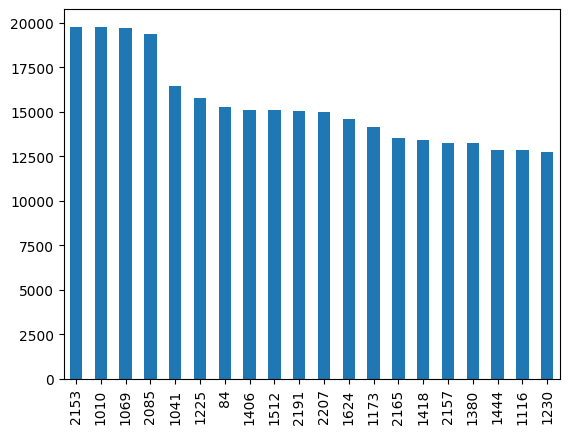

In [47]:
save = feats.get_station_freq()
save.sort_values(ascending = False).head(20).plot.bar()

In [ ]:
size_stmt_from_df(feats.main_df.drop(columns = ['ride_id']))

Bytes: 41717414
Digits: Tens of millions
Simplified: 39.78 MB


41717414

In [39]:
feats.get_distance_per_station()

1        1180.1865
2        6800.6951
3       10634.1147
4        1545.7246
5         625.5306
           ...    
2124      101.3545
2125       30.8983
2126        3.6718
2127       20.4147
2128       87.8954
Name: total_distances, Length: 2096, dtype: float64

In [ ]:
df = pd.DataFrame()

chunk_size = int(1e5)
size = df.shape[0]
num_chunks = ceil(size / chunk_size)

df_chunks = []
for i in range(num_chunks):
    chunk = df.loc[i * size : (i+1) * size]
    df_chunks.append(chunk)

In [ ]:
test_df = pd.DataFrame()

for df in df_chunks:
    test_df = pd.concat([test_df, df])

In [ ]:
test_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5511719F60A614AA,classic_bike,2023-07-10 20:07:52.959,2023-07-10 20:20:16.918,E 27 St & Park Ave S,6131.13,1 Ave & E 39 St,6303.01,40.742752,-73.984716,40.747140,-73.971130,casual
1,0747E080C54F7AAE,classic_bike,2023-07-17 15:30:30.216,2023-07-17 15:33:10.123,South St & Gouverneur Ln,4953.04,Maiden Ln & Pearl St,5065.10,40.703554,-74.006702,40.707065,-74.007319,member
2,1243D8C21B002936,classic_bike,2023-07-30 16:21:26.583,2023-07-30 16:38:17.095,South St & Gouverneur Ln,4953.04,St Marks Pl & 2 Ave,5669.10,40.703554,-74.006702,40.728419,-73.987140,member
3,82B9DB6B37D6104F,classic_bike,2023-07-31 17:22:49.480,2023-07-31 17:33:48.668,Forsyth St & Canal St,5270.07,Maiden Ln & Pearl St,5065.10,40.715815,-73.994224,40.707065,-74.007319,member
4,23E978F5180198F1,classic_bike,2023-07-11 18:25:52.841,2023-07-11 18:36:15.167,34 Ave & 45 St,6596.10,31 St & 23 Ave,7144.01,40.754795,-73.917014,40.774788,-73.912555,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659576,832CA1B4855C70A5,electric_bike,2023-07-13 05:27:33.831,2023-07-13 05:54:28.704,Irving Ave & Harman St,4856.05,48 St & Broadway,6629.06,40.700916,-73.918112,40.755763,-73.912715,member
659577,8557BC1F7CCA1C6A,electric_bike,2023-07-11 19:06:35.962,2023-07-11 19:12:58.083,Madison St & Clinton St,5190.07,Canal St & Rutgers St,5303.08,40.712663,-73.987653,40.714275,-73.989900,member
659578,BE271830E3562BE2,electric_bike,2023-07-17 17:09:37.585,2023-07-17 17:15:17.400,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719961,-74.008443,40.709056,-74.010434,member
659579,90C7E9A95C19F0EA,electric_bike,2023-07-25 15:17:57.952,2023-07-25 15:21:48.394,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719931,-74.008355,40.709056,-74.010434,member
